In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 26/1/2021 QAAFI UQ
# Code functionalities:
# Import apsim classic files and compare OBS vs PRE data
# Read several files from a folder and merge them in a single pandas dataframe
# Create scatter plots and add error bars
#####################################################################################################################

In [2]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-2-f27bbb6f6f6b>:28: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [7]:
#read simulated data from APSIM Classic out files
filelist = glob.glob(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\*HarvestReport.out')
frame = pd.DataFrame()
list = []

for file in filelist:
    df = pd.read_csv(file)
    df.drop(df.index[[0,2]])
    df[['date','year','day','DaysAfterSowing','biomass','stage','StageName','TotalTT()','Title']] = df['ApsimVersion = 7.10 r4210'].str.split(n=9, expand=True)
    a = df.drop(['ApsimVersion = 7.10 r4210'], axis=1)
    b = a.drop(df.index[[0,1,2]])
    #Create categories
    b['location'] = b['Title'].str.slice(0,2)
    b['state'] = b['Title'].str.slice(3,5)
    b['cultivar'] = b['Title'].str.slice(6,8)
    b['nitrogen'] = b['Title'].str.slice(9,13)
    b['year2'] = b['Title'].str.slice(14,19)
    #Change dtype from string to float
    b["day"] = b["day"].astype(str).astype(float)
    b["DaysAfterSowing"] = b["DaysAfterSowing"].astype(str).astype(float)
    b["biomass"] = b["biomass"].astype(str).astype(float)
    b["stage"] = b["stage"].astype(str).astype(float)
    b["TotalTT()"] = b["TotalTT()"].astype(str).astype(float)
    #Rename
    b.rename(columns={'biomass':'sim_biomass'}, inplace=True)
    #Create new categories
    b["name"] = b["state"] + "_" + b["location"] + "_" + b["cultivar"] + "_" + b["year"] + "_" + b["nitrogen"] + "_" + b["year2"] 
    b["env"] = b["location"] + "-" + b["state"]
    b["envyear"] = b["env"] + "-" + b["year"]
    
    list.append(b)
    
all_sim = pd.concat(list)

#read observed data
obs = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\observed.csv')
obs['year'] = obs['year'].astype(object)
obs.rename(columns={'biomass':'obs_biomass'}, inplace=True)

#merge obs and pre data
df000 = pd.merge(all_sim, obs, on=["name"], how="inner")
df00=df000.drop(['year_x','location_x','cultivar_x','state_x','nitrogen_x','year2_x'],axis=1)
df00.rename(columns={'year_y':'year','location_y':'location','cultivar_y':'cultivar','state_y':'state','nitrogen_y':'nitrogen','year2_y':'year2'}, inplace=True)
df00['delta'] = df00['obs_biomass']-df00['sim_biomass']

#clean some data with suspicious deviations between reps and data from other sources than SunGrant
#df00b = df00.loc[df00.env != 'We-TX']
df00c = df00.loc[df00.envyear != 'CC-TX-2008']
df = df00c.drop(df00c.index[[130, 145]])
a = ['MS_Ra_ES_2012_N200_Y_ALL','MS_Ra_M8_2010_N200_Y_ALL','TX_We_4E_2009_N000_Y2009','TX_We_4E_2009_N280_Y2009',
    'MS_Ra_ES_2011_N200_Y_ALL', 'MS_Ra_GN_2011_N200_Y_ALL']
df = df[~df['name'].isin(a)]

#Getting 15% off from Wa-NC biomass due to was harvested from 15 cm 
df.loc[df['env'] == 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']*0.85
df.loc[df['env'] != 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']

#read Purdue data
purdue = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\purdue.csv')

In [497]:
#df.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\df_final.csv')

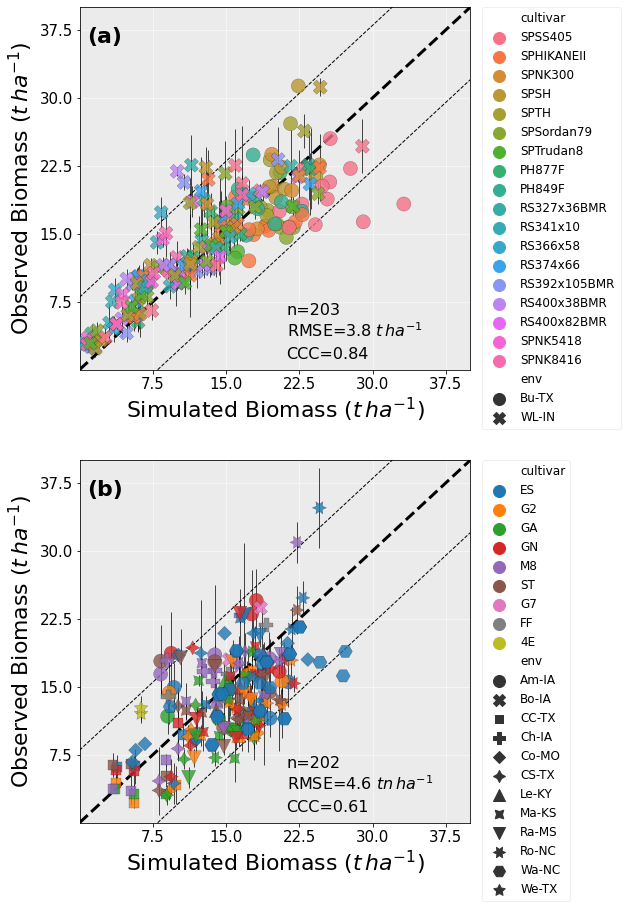

In [34]:
purdue['obs_biomass2'] = purdue['obs_biomass']/1000
purdue['sim_biomass2'] = purdue['sim_biomass']/1000
purdue['error_biomass2'] = purdue['error_biomass']/1000
df['obs_biomass2'] = df['obs_biomass']/1000
df['sim_biomass2'] = df['sim_biomass']/1000
df['biomassError2'] = df['biomassError']/1000

#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(7,15))

ax=plt.subplot(2, 1, 1)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(purdue['sim_biomass2'], purdue['obs_biomass2'], yerr = purdue['error_biomass2'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass2",hue='cultivar', style='env', alpha=0.8, data=purdue, linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(purdue.obs_biomass2.values)
y_o= Obs.tolist()
Pre = pd.Series(purdue.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

ax=plt.subplot(2, 1, 2)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(df['sim_biomass2'], df['obs_biomass2'], yerr = df['biomassError2'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass2",hue='cultivar', style='env', alpha=0.8,data=df,linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df.obs_biomass2.values)
y_o= Obs.tolist()
Pre = pd.Series(df.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'(b)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $tn\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Figs\val2.png', dpi=300,bbox_inches='tight')
hide_toggle()

In [17]:
df

,date,day,DaysAfterSowing,sim_biomass,stage,StageName,TotalTT(),Title,name,env,...,state,location,cultivar,year,nitrogen,year2,obs_biomass,biomassError,delta,sim_biomass2
0,09/15/2009,258.0,118.0,19494.2,5.934,floral_initiation,983.881,Am_IA_ES_N200_Y_ALL,IA_Am_ES_2009_N200_Y_ALL,Am-IA,...,IA,Am,ES,2009,N200,Y_ALL,11524.8,2078.8,-7969.4,19494.20
1,09/15/2010,258.0,118.0,21380.3,6.716,flag_leaf,1143.303,Am_IA_ES_N200_Y_ALL,IA_Am_ES_2010_N200_Y_ALL,Am-IA,...,IA,Am,ES,2010,N200,Y_ALL,15532.8,2754.8,-5847.5,21380.30
2,09/15/2011,258.0,118.0,18803.1,8.007,start_grain_fill,1248.452,Am_IA_ES_N200_Y_ALL,IA_Am_ES_2011_N200_Y_ALL,Am-IA,...,IA,Am,ES,2011,N200,Y_ALL,17398.4,2282.4,-1404.7,18803.10
3,09/15/2012,259.0,118.0,9682.3,6.797,flag_leaf,1151.900,Am_IA_ES_N200_Y_ALL,IA_Am_ES_2012_N200_Y_ALL,Am-IA,...,IA,Am,ES,2012,N200,Y_ALL,14922.3,2686.4,5240.0,9682.30
4,09/15/2009,258.0,118.0,18218.2,8.117,start_grain_fill,1025.848,Am_IA_G2_N200_Y_ALL,IA_Am_G2_2009_N200_Y_ALL,Am-IA,...,IA,Am,G2,2009,N200,Y_ALL,11443.1,1350.4,-6775.1,18218.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,10/09/2014,282.0,142.0,22542.4,11.000,harvest_ripe,1782.726,Wa_NC_ES_N268_Y2014,NC_Wa_ES_2014_N268_Y2014,Wa-NC,...,NC,Wa,ES,2014,N268,Y2014,21585.0,NaN,-957.4,19161.04
209,09/14/2015,257.0,144.0,20982.4,11.000,harvest_ripe,1832.869,Wa_NC_ES_N268_Y2015,NC_Wa_ES_2015_N268_Y2015,Wa-NC,...,NC,Wa,ES,2015,N268,Y2015,11500.0,NaN,-9482.4,17835.04
210,09/14/2015,257.0,144.0,20982.4,11.000,harvest_ripe,1832.869,Wa_NC_ES_N268_Y2015,NC_Wa_ES_2015_N268_Y2015,Wa-NC,...,NC,Wa,ES,2015,N268,Y2015,11446.0,NaN,-9536.4,17835.04
211,08/14/2008,227.0,114.0,6297.0,5.963,floral_initiation,998.256,We_TX_4E_N000_Y2008,TX_We_4E_2008_N000_Y2008,We-TX,...,TX,We,4E,2008,N000,Y2008,12030.8,1021.2,5733.8,6297.00


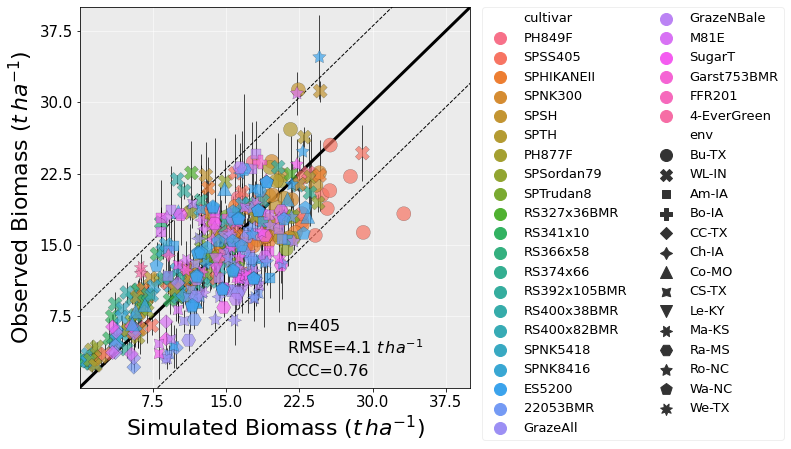

In [21]:
#read all data
final = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\all.csv')
final['sim_biomass2'] = final['sim_biomass']/1000
final['obs_biomass2'] = final['obs_biomass']/1000
final['biomassError2'] = final['biomassError']/1000

#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(7,7))

ax=plt.subplot(1, 1, 1)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(final['sim_biomass2'], final['obs_biomass2'], yerr = final['biomassError2'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass2",hue='cultivar', style='env', alpha=0.7, data=final, linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=2,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final.obs_biomass2.values)
y_o= Obs.tolist()
Pre = pd.Series(final.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
#plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Figs\val.png', dpi=300,bbox_inches='tight')
hide_toggle()

In [22]:
final

,cultivar,env,Year,obs_biomass,biomassError,sim_biomass,DAS,sim_biomass2,obs_biomass2,biomassError2
0,PH849F,Bu-TX,2017,17755.39256,NaN,18238.87,113,18.23887,17.755393,NaN
1,SPSS405,Bu-TX,2017,20258.25169,NaN,24837.50,135,24.83750,20.258252,NaN
2,PH849F,Bu-TX,2016,23694.77929,NaN,17768.75,99,17.76875,23.694779,NaN
3,SPHIKANEII,Bu-TX,2016,14044.25660,NaN,14104.30,80,14.10430,14.044257,NaN
4,SPNK300,Bu-TX,2016,23773.23882,NaN,19681.08,110,19.68108,23.773239,NaN
...,...,...,...,...,...,...,...,...,...,...
400,ES5200,Wa-NC,2014,21585.00000,NaN,19161.04,142,19.16104,21.585000,NaN
401,ES5200,Wa-NC,2015,11500.00000,NaN,17835.04,144,17.83504,11.500000,NaN
402,ES5200,Wa-NC,2015,11446.00000,NaN,17835.04,144,17.83504,11.446000,NaN
403,4-EverGreen,We-TX,2008,12030.80000,1021.2,6297.00,114,6.29700,12.030800,1.0212


In [495]:
df.loc[df['delta'] > 8000]

,date,day,DaysAfterSowing,sim_biomass,stage,StageName,TotalTT(),Title,name,env,...,state,location,cultivar,year,nitrogen,year2,obs_biomass,biomassError,delta,sim_biomass2
15,09/15/2012,259.0,118.0,9384.0,8.808,start_grain_fill,1294.447,Am_IA_GN_N200_Y_ALL,IA_Am_GN_2012_N200_Y_ALL,Am-IA,...,IA,Am,GN,2012,N200,Y_ALL,18694.9,4564.8,9310.9,9384.0
19,09/15/2012,259.0,118.0,8302.8,6.044,flag_leaf,1177.676,Am_IA_M8_N200_Y_ALL,IA_Am_M8_2012_N200_Y_ALL,Am-IA,...,IA,Am,M8,2012,N200,Y_ALL,16401.7,2314.4,8098.9,8302.8
23,09/15/2012,259.0,118.0,8302.8,6.044,flag_leaf,1177.676,Am_IA_ST_N200_Y_ALL,IA_Am_ST_2012_N200_Y_ALL,Am-IA,...,IA,Am,ST,2012,N200,Y_ALL,17829.8,4008.1,9527.0,8302.8
54,09/15/1988,259.0,118.0,8941.9,6.673,flag_leaf,1293.389,Ch_IA_M8_N200_Y_ALL,IA_Ch_M8_1988_N200_Y_ALL,Ch-IA,...,IA,Ch,M8,1988,N200,Y_ALL,17900.0,NaN,8958.1,8941.9
61,10/25/2010,298.0,130.0,10120.5,5.926,floral_initiation,989.489,Co_MO_ES_N056_Y2010,MO_Co_ES_2010_N056_Y2010,Co-MO,...,MO,Co,ES,2010,N056,Y2010,18500.0,NaN,8379.5,10120.5
157,10/01/2009,274.0,115.0,24557.1,8.805,start_grain_fill,1570.570,Ro_NC_ES_N200_Y_ALL,NC_Ro_ES_2009_N200_Y_ALL,Ro-NC,...,NC,Ro,ES,2009,N200,Y_ALL,34744.7,4401.5,10187.6,24557.1
173,10/01/2009,274.0,115.0,22261.0,8.413,start_grain_fill,1570.570,Ro_NC_M8_N200_Y_ALL,NC_Ro_M8_2009_N200_Y_ALL,Ro-NC,...,NC,Ro,M8,2009,N200,Y_ALL,30932.0,2296.7,8671.0,22261.0
212,12/31/2009,365.0,257.0,4608.5,8.983,start_grain_fill,1526.052,We_TX_4E_N000_Y2009,TX_We_4E_2009_N000_Y2009,We-TX,...,TX,We,4E,2009,N000,Y2009,28389.9,2663.0,23781.4,4608.5
213,12/31/2009,365.0,263.0,10095.5,11.000,harvest_ripe,1797.561,We_TX_4E_N280_Y2009,TX_We_4E_2009_N280_Y2009,We-TX,...,TX,We,4E,2009,N280,Y2009,23587.0,2282.6,13491.5,10095.5
